<a href="https://www.kaggle.com/code/jiyana63/derin-renme-ali-mas?scriptVersionId=285728725" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# Gerekli kütüphaneleri yükleyelim
!pip install ultralytics torchmetrics -q

import os
import yaml
import random
import cv2
import numpy as np
import torch
import matplotlib.pyplot as plt
from PIL import Image

# PyTorch ve Model Kütüphaneleri
from torch.utils.data import Dataset, DataLoader
from torchvision.models.detection import fasterrcnn_resnet50_fpn_v2, ssdlite320_mobilenet_v3_large, retinanet_resnet50_fpn_v2
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.retinanet import RetinaNetHead
from torch.optim import SGD
from ultralytics import YOLO

# Metrikler
try:
    from torchmetrics.detection.mean_ap import MeanAveragePrecision
except ImportError:
    print("Torchmetrics yüklenemedi, metrik hesaplaması çalışmayabilir.")

# Cihaz ayarı (GPU varsa kullan)
DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(f"✅ Çalışma ortamı hazır. Cihaz: {DEVICE}")

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
✅ Çalışma ortamı hazır. Cihaz: cuda


In [2]:
# --- AYARLAR ---
EPOCHS = 5          # Ödev isterine göre 100 olmalı (Test için 5-10 yapabilirsin)
BATCH_SIZE = 4        # GPU hafızası yetmezse 2'ye düşür
IMG_SIZE = 320        # Görüntü boyutu
NUM_CLASSES_PT = 2    # PyTorch için: 0=Background, 1=Person

# --- VERİ YOLU BULMA ---
start_dir = "/kaggle/input"
root_dir = ""

print("🕵️‍♂️ Veri seti aranıyor...")
for dirpath, dirnames, filenames in os.walk(start_dir):
    if "train" in dirnames and "valid" in dirnames:
        root_dir = dirpath
        break

if root_dir:
    train_path = os.path.join(root_dir, "train")
    valid_path = os.path.join(root_dir, "valid")
    print(f"✅ Veri seti bulundu: {root_dir}")
else:
    print("❌ HATA: Veri seti bulunamadı! Lütfen Kaggle sağ menüden veri setini eklediğine emin ol.")

# --- YOLO İÇİN YAML OLUŞTURMA ---
if root_dir:
    data_yaml = {
        'train': os.path.join(train_path, "images"),
        'val': os.path.join(valid_path, "images"),
        'nc': 1,
        'names': ['person']
    }
    with open('dataset.yaml', 'w') as f:
        yaml.dump(data_yaml, f)
    print("✅ YOLO için 'dataset.yaml' oluşturuldu.")

🕵️‍♂️ Veri seti aranıyor...
✅ Veri seti bulundu: /kaggle/input/thermal-image-people-detection/People Detection - Themal
✅ YOLO için 'dataset.yaml' oluşturuldu.


In [3]:
class ThermalDataset(Dataset):
    def __init__(self, root_dir, transforms=None):
        self.root_dir = root_dir
        self.transforms = transforms
        self.image_dir = os.path.join(root_dir, "images")
        self.label_dir = os.path.join(root_dir, "labels")
        self.imgs = sorted([f for f in os.listdir(self.image_dir) if f.endswith(('.jpg', '.png', '.jpeg'))])

    def __getitem__(self, idx):
        img_name = self.imgs[idx]
        img_path = os.path.join(self.image_dir, img_name)
        label_path = os.path.join(self.label_dir, os.path.splitext(img_name)[0] + ".txt")

        # Resmi oku ve RGB yap
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        h, w, _ = img.shape
        img_pil = Image.fromarray(img)

        boxes = []
        labels = []

        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                lines = f.readlines()
                for line in lines:
                    parts = list(map(float, line.strip().split()))
                    if len(parts) == 5:
                        cls, cx, cy, bw, bh = parts
                        # YOLO formatından (normalize) -> Pascal VOC formatına (piksel) çevir
                        x_min = (cx - bw/2) * w
                        y_min = (cy - bh/2) * h
                        x_max = (cx + bw/2) * w
                        y_max = (cy + bh/2) * h

                        # Hatalı kutuları engelle
                        if x_max > x_min and y_max > y_min:
                            boxes.append([x_min, y_min, x_max, y_max])
                            labels.append(1) # 1: Person

        # Tensörlere çevir
        target = {}
        if len(boxes) > 0:
            target["boxes"] = torch.as_tensor(boxes, dtype=torch.float32)
            target["labels"] = torch.as_tensor(labels, dtype=torch.int64)
            target["area"] = (target["boxes"][:, 3] - target["boxes"][:, 1]) * (target["boxes"][:, 2] - target["boxes"][:, 0])
            target["iscrowd"] = torch.zeros((len(labels),), dtype=torch.int64)
            target["image_id"] = torch.tensor([idx])
        else:
            # Kutu yoksa boş tensör gönder
            target["boxes"] = torch.zeros((0, 4), dtype=torch.float32)
            target["labels"] = torch.zeros((0,), dtype=torch.int64)
            target["area"] = torch.zeros((0,), dtype=torch.float32)
            target["iscrowd"] = torch.zeros((0,), dtype=torch.int64)
            target["image_id"] = torch.tensor([idx])

        if self.transforms:
            from torchvision import transforms as T
            # Sadece ToTensor uyguluyoruz, gerekirse augmentasyon eklenebilir
            t = T.Compose([T.ToTensor()])
            img_tensor = t(img_pil)
        
        return img_tensor, target

    def __len__(self):
        return len(self.imgs)

def collate_fn(batch):
    return tuple(zip(*batch))

# Datasetleri Oluştur
train_dataset = ThermalDataset(train_path, transforms=True)
valid_dataset = ThermalDataset(valid_path, transforms=True)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn, num_workers=2)
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn, num_workers=2)

print(f"✅ Dataset Hazır. Train: {len(train_dataset)}, Valid: {len(valid_dataset)} görsel.")

✅ Dataset Hazır. Train: 21422, Valid: 3061 görsel.


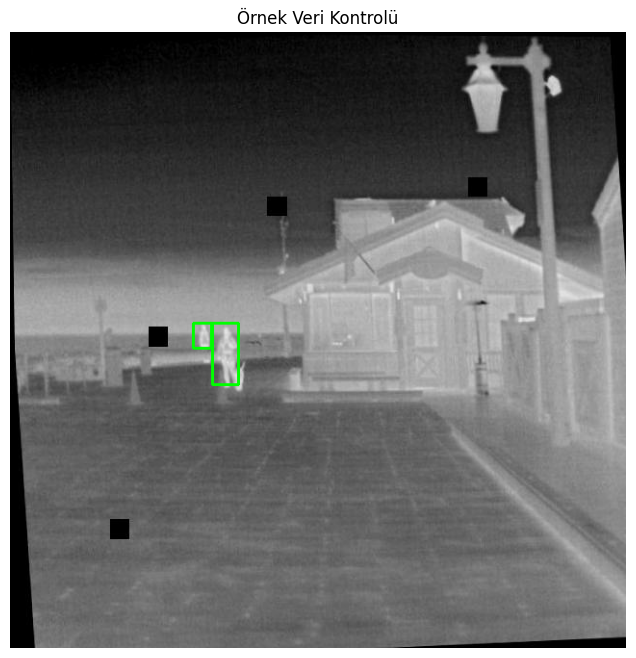

In [4]:
def visualize_sample(loader):
    images, targets = next(iter(loader))
    img = images[0].permute(1, 2, 0).cpu().numpy().copy()
    boxes = targets[0]['boxes'].cpu().numpy()
    
    plt.figure(figsize=(10,8))
    for box in boxes:
        x_min, y_min, x_max, y_max = box.astype(int)
        cv2.rectangle(img, (x_min, y_min), (x_max, y_max), (0, 255, 0), 2)
    
    plt.imshow(img)
    plt.title("Örnek Veri Kontrolü")
    plt.axis('off')
    plt.show()

try:
    visualize_sample(train_loader)
except Exception as e:
    print(f"Görselleştirme hatası: {e}")

In [5]:
def train_model(model, loader, epochs, name):
    print(f"\n🚀 [{name}] Eğitimi Başlıyor... ({epochs} Epoch)")
    model.to(DEVICE)
    params = [p for p in model.parameters() if p.requires_grad]
    optimizer = SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
    
    model.train()
    loss_history = []
    
    for epoch in range(epochs):
        epoch_loss = 0
        batch_count = 0
        
        for images, targets in loader:
            images = [img.to(DEVICE) for img in images]
            targets = [{k: v.to(DEVICE) for k, v in t.items()} for t in targets]
            
            loss_dict = model(images, targets)
            losses = sum(loss for loss in loss_dict.values())
            
            optimizer.zero_grad()
            losses.backward()
            optimizer.step()
            
            epoch_loss += losses.item()
            batch_count += 1
        
        avg_loss = epoch_loss/batch_count
        loss_history.append(avg_loss)
        
        if (epoch+1) % 10 == 0 or epoch == 0:
            print(f"   Epoch {epoch+1}/{epochs} | Loss: {avg_loss:.4f}")
            
    print(f"✅ {name} Eğitimi Tamamlandı.")
    return model, loss_history

In [6]:
print("=== MODEL 1: YOLOv8m Eğitimi ===")

model_yolo = YOLO('yolov8m.pt') 

results_yolo = model_yolo.train(
    data='dataset.yaml',
    epochs=EPOCHS,
    imgsz=IMG_SIZE,
    batch=8, # YOLO genelde daha optimize çalışır, batch'i artırabilirsin
    name='yolo_thermal_project',
    verbose=False
)

print("YOLO eğitimi bitti.")

=== MODEL 1: YOLOv8m Eğitimi ===
Ultralytics 8.3.236 🚀 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=dataset.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=320, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8m.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=yolo_thermal_project, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100,

2025-12-12 12:13:29,357	INFO util.py:124 -- Outdated packages:
  ipywidgets==7.7.1 found, needs ipywidgets>=8
Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2025-12-12 12:13:30,257	INFO util.py:124 -- Outdated packages:
  ipywidgets==7.7.1 found, needs ipywidgets>=8
Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


Overriding model.yaml nc=80 with nc=1

                   from  n    params  module                                       arguments                     
  0                  -1  1      1392  ultralytics.nn.modules.conv.Conv             [3, 48, 3, 2]                 
  1                  -1  1     41664  ultralytics.nn.modules.conv.Conv             [48, 96, 3, 2]                
  2                  -1  2    111360  ultralytics.nn.modules.block.C2f             [96, 96, 2, True]             
  3                  -1  1    166272  ultralytics.nn.modules.conv.Conv             [96, 192, 3, 2]               
  4                  -1  4    813312  ultralytics.nn.modules.block.C2f             [192, 192, 4, True]           
  5                  -1  1    664320  ultralytics.nn.modules.conv.Conv             [192, 384, 3, 2]              
  6                  -1  4   3248640  ultralytics.nn.modules.block.C2f             [384, 384, 4, True]           
  7                  -1  1   1991808  ultralytics

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 192/192 10.1it/s 19.0s.1ss
                   all       3061       6698      0.771      0.595      0.682      0.291

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
        4/5      1.51G      1.731      1.105      1.134         13        320: 100% ━━━━━━━━━━━━ 2678/2678 7.8it/s 5:44<0.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 192/192 10.3it/s 18.7s0.2s
                   all       3061       6698      0.772      0.652      0.728      0.316

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
        5/5      1.51G      1.652     0.9988      1.097         18        320: 100% ━━━━━━━━━━━━ 2678/2678 7.8it/s 5:45<0.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 192/192 10.2it/s 18.8s0.2s
         

In [ ]:
print("=== MODEL 2: Faster R-CNN (ResNet-50) Eğitimi ===")

# Modeli Yükle
model_frcnn = fasterrcnn_resnet50_fpn_v2(weights="DEFAULT")

# Çıkış katmanını (Head) değiştir (2 Sınıf: Background + Person)
in_features = model_frcnn.roi_heads.box_predictor.cls_score.in_features
model_frcnn.roi_heads.box_predictor = FastRCNNPredictor(in_features, NUM_CLASSES_PT)

# Eğit
trained_frcnn, loss_frcnn = train_model(model_frcnn, train_loader, EPOCHS, "Faster R-CNN")

=== MODEL 2: Faster R-CNN (ResNet-50) Eğitimi ===

🚀 [Faster R-CNN] Eğitimi Başlıyor... (5 Epoch)


In [ ]:
print("=== MODEL 3: RetinaNet Eğitimi ===")

# Modeli Yükle
model_retina = retinanet_resnet50_fpn_v2(weights="DEFAULT")

# Head katmanını değiştir
num_anchors = model_retina.head.classification_head.num_anchors
model_retina.head = RetinaNetHead(in_channels=256, num_anchors=num_anchors, num_classes=NUM_CLASSES_PT)

# Eğit (Eğer CUDA hatası alırsan batch size'ı düşür)
trained_retina, loss_retina = train_model(model_retina, train_loader, EPOCHS, "RetinaNet")

In [ ]:
print("=== MODEL 4: SSDLite (MobileNetV3) Eğitimi ===")

# 1. Pretrained ağırlıkları al
base_model = ssdlite320_mobilenet_v3_large(weights="DEFAULT")
pretrained_dict = base_model.state_dict()

# 2. Yeni boş model oluştur (Bizim sınıf sayımızla)
model_ssd = ssdlite320_mobilenet_v3_large(weights=None, num_classes=NUM_CLASSES_PT)
model_dict = model_ssd.state_dict()

# 3. Sadece uyuşan katmanları kopyala (Head hariç)
filtered_dict = {k: v for k, v in pretrained_dict.items() if k in model_dict and v.shape == model_dict[k].shape}
model_dict.update(filtered_dict)
model_ssd.load_state_dict(model_dict)

print("✅ SSDLite ağırlıkları başarıyla aktarıldı.")

# Eğit
trained_ssd, loss_ssd = train_model(model_ssd, train_loader, EPOCHS, "SSDLite")

In [ ]:
def evaluate_pytorch(model, loader, device):
    model.eval()
    metric = MeanAveragePrecision(iou_type="bbox")
    
    with torch.no_grad():
        for images, targets in loader:
            images = [img.to(device) for img in images]
            preds = model(images)
            
            # CPU'ya alıp formata uygun hale getir
            preds_cpu = [{k: v.to("cpu") for k, v in p.items()} for p in preds]
            targets_cpu = [{k: v.to("cpu") for k, v in t.items()} for t in targets]
            
            metric.update(preds_cpu, targets_cpu)
            
    result = metric.compute()
    return result['map_50'].item(), result['map'].item()

print("\n📊 --- FİNAL SONUÇLARI HESAPLANIYOR ---")

# 1. YOLO Sonuçları
yolo_map50 = results_yolo.box.map50
yolo_map = results_yolo.box.map

# 2. PyTorch Modelleri
frcnn_map50, frcnn_map = evaluate_pytorch(trained_frcnn, valid_loader, DEVICE)
retina_map50, retina_map = evaluate_pytorch(trained_retina, valid_loader, DEVICE)
ssd_map50, ssd_map = evaluate_pytorch(trained_ssd, valid_loader, DEVICE)

# Tabloyu Yazdır
print("\n" + "="*65)
print(f"| {'MODEL ADI':<20} | {'mAP@0.50 (Doğruluk)':<20} | {'mAP@0.50:0.95':<15} |")
print(f"|{'-'*22}|{'-'*22}|{'-'*17}|")
print(f"| {'YOLOv8m':<20} | {yolo_map50:.4f}               | {yolo_map:.4f}          |")
print(f"| {'Faster R-CNN':<20} | {frcnn_map50:.4f}               | {frcnn_map:.4f}          |")
print(f"| {'RetinaNet':<20} | {retina_map50:.4f}               | {retina_map:.4f}          |")
print(f"| {'SSDLite':<20} | {ssd_map50:.4f}               | {ssd_map:.4f}          |")
print("="*65)